In [126]:
import os
import pandas as pd
import numpy as np
import pickle
import glob
import json
from json import JSONDecodeError
import requests
import csv
from collections import Counter,defaultdict
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Strategies:
1. filter out users with highest number of comments posted (within timeframe of interest)
1. remove usernames ending in “bot”

In [2]:
reddit_dir = 'reddit_data'

In [3]:
posts_df = pd.read_pickle(os.path.join(reddit_dir,'posts_with_words.pkl'))
posts_df.shape

(975950, 18)

In [151]:
pickle.dump(list(posts_df.id),open('posts_with_words_ids.pkl','wb'))

In [4]:
comments_df = pd.read_pickle(os.path.join(reddit_dir,'comments_complete.pkl'))
comments_df.shape

(7991395, 10)

Strategy 2: Users ending in "bot"

In [41]:
post_authors = set(posts_df.author)
len(post_authors)

248378

In [8]:
comment_authors = set(comments_df.author)
len(comment_authors)

1905004

In [10]:
post_authors_end_bot = [x for x in post_authors if x is not None and x[-3:].lower()=='bot']
comment_authors_end_bot = [x for x in comment_authors if x[-3:].lower()=='bot']
print(len(post_authors_end_bot),len(comment_authors_end_bot))

562 2449


In [15]:
all_authors_end_bot = set(post_authors_end_bot) | set(comment_authors_end_bot)
len(all_authors_end_bot)

2805

Strategy 1: Users with highest number of comments

In [71]:
comments_per_user_2019_2020 = defaultdict(int)

In [65]:
def getPushshiftData(author, after, before):
    url = 'https://api.pushshift.io/reddit/search/?'+'author='+author+'&size=1000&after='+str(after)+'&before='+str(before)
    #print(url)
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']

In [88]:
def pushshift_wrapper(after_str, before_str, author, keywords=None):
    failed_requests = []
    
    subCount = 0
    before_date = datetime.datetime.strptime(before_str, "%m-%d-%Y")
    after_date = datetime.datetime.strptime(after_str, "%m-%d-%Y")
    before_timestamp = int(datetime.datetime.timestamp(before_date))
    after_timestamp = int(datetime.datetime.timestamp(after_date))
    #print("Getting all comments from user '{}' from {} to {}".format(author,after_str,before_str))
    try:
        data = getPushshiftData(author, after_timestamp, before_timestamp)
        # Will run until all posts have been gathered 
        # from the 'after' date up until before date
        while len(data) > 0:
            #print('len data:',len(data))
            for submission in data:
                subCount+=1
            after_timestamp = data[-1]['created_utc']
            try:
                #print('after timestamp:',after_timestamp)
                data = getPushshiftData(author, after_timestamp, before_timestamp)
            except JSONDecodeError:
                failed_requests.append((author,after_timestamp,before_timestamp))

        #print('Num comments:',subCount)
        comments_per_user_2019_2020[author] += subCount
        
            
    except JSONDecodeError:
        failed_requests.append((author,after_timestamp,before_timestamp))
        print("First request failed")

In [28]:
all_authors = post_authors | comment_authors
len(all_authors)

2028614

In [30]:
all_authors = list(all_authors)

In [76]:
all_authors.index(redditor)

12

In [130]:
ix_redditor

22485

In [131]:
for ix_redditor in range(22485,len(all_authors)):
    redditor = all_authors[ix_redditor]
    pushshift_wrapper('7-20-2019','7-20-2020',redditor)
    
    if ix_redditor % 5000 == 0:
        print(ix_redditor)

First request failed
First request failed
First request failed
First request failed
First request failed
First request failed
First request failed
First request failed
First request failed
First request failed
First request failed
First request failed
First request failed
First request failed
First request failed
First request failed
First request failed
First request failed
First request failed
First request failed
First request failed
First request failed
First request failed
First request failed
First request failed


KeyboardInterrupt: 

In [91]:
len(comments_per_user_2019_2020)

8949

In [107]:
comments_per_user_df = pd.DataFrame(comments_per_user_2019_2020,index=[0]).T

In [108]:
comments_per_user_df['username'] = comments_per_user_df.index.copy()
comments_per_user_df.reset_index(drop=True,inplace=True)
comments_per_user_df['ends_in_bot'] = comments_per_user_df.username.apply(lambda x: str(x).lower()[-3:] == 'bot')

In [109]:
comments_per_user_df.ends_in_bot.value_counts()

False    8937
True       12
Name: ends_in_bot, dtype: int64

In [127]:
comments_per_user_df['log_count'] = comments_per_user_df[0].apply(lambda x: np.log(x+0.001))

/u/nlp/anaconda/main/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


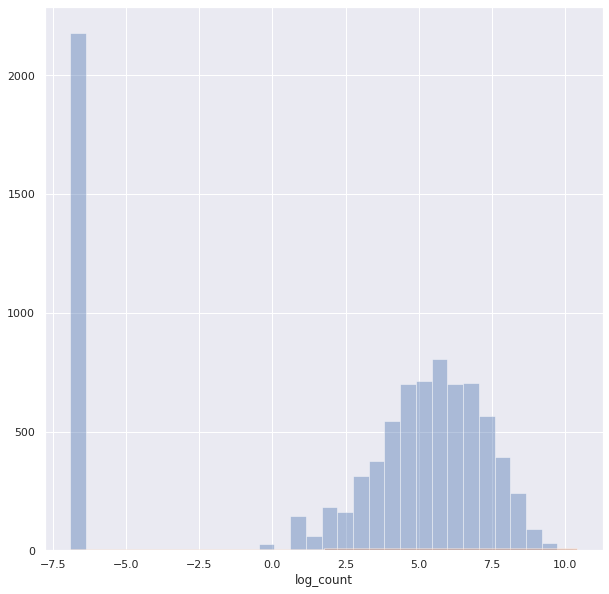

In [128]:
fig, ax = plt.subplots(figsize=(10, 10))
for group in comments_per_user_df.ends_in_bot.unique():
    sns.distplot(comments_per_user_df.loc[comments_per_user_df.ends_in_bot == group, 'log_count'],
                 kde=False, ax=ax, label=group)

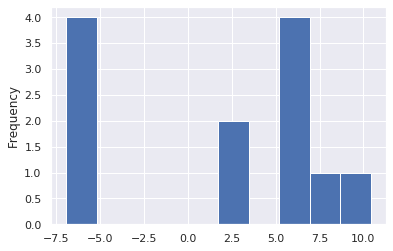

In [129]:
comments_per_user_df.loc[comments_per_user_df.ends_in_bot == True]['log_count'].plot.hist()

In [134]:
# Save list of bots
all_bots = all_authors_end_bot.copy()
len(all_bots)
pickle.dump(all_bots,open('bots.pkl','wb'))